In [112]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [113]:
import matlab.engine
eng = matlab.engine.start_matlab()


In [114]:
eng.addpath(r"C:\optical\Coherent-Optical-Communication\Coherent-Optical-Communication\functions\DSP", nargout=0)

In [115]:
def apply_pmd(E_in, DGD_ps_per_sqrt_km, L_m, N_sections, Rs, SpS):

    N_samples = E_in.shape[0]
    SD_tau = np.sqrt(3 * np.pi / 8) * DGD_ps_per_sqrt_km

    tau = (SD_tau * np.sqrt(L_m * 1e-3) / np.sqrt(N_sections)) * 1e-12
    #tau=0
    w = 2 * np.pi * np.fft.fftshift(np.linspace(-0.5, 0.5, N_samples)) * SpS * Rs

    E_V = np.fft.fft(E_in[:, 0])
    E_H = np.fft.fft(E_in[:, 1])

    for _ in range(N_sections):
        # Random complex coupling matrices (unitary)
        X = np.random.randn(2, 2) + 1j * np.random.randn(2, 2)
        U, _, Vh = np.linalg.svd(X)
        V = Vh.conj().T
        #print("U is",U)
        # Rotate fields by U†
        E1 = U[0, 0].conj() * E_V + U[0, 1].conj() * E_H
        E2 = U[1, 0].conj() * E_V + U[1, 1].conj() * E_H

        # Apply differential delay
        E1 *= np.exp(1j * w * tau / 2)
        E2 *= np.exp(-1j * w * tau / 2)

        # Rotate by V
        E_V = V[0, 0] * E1 + V[0, 1] * E2
        E_H = V[1, 0] * E1 + V[1, 1] * E2

    E_out_x = np.fft.ifft(E_V)
    E_out_y = np.fft.ifft(E_H)

    return np.column_stack((E_out_x, E_out_y))


In [116]:
N_symbols = 10000
levels = np.array([-1, 1]) / np.sqrt(2)
qam_symbols_x = (np.random.choice(levels, N_symbols) +
               1j * np.random.choice(levels, N_symbols))
qam_symbols_y = (np.random.choice(levels, N_symbols) +
               1j * np.random.choice(levels, N_symbols))

E_in = np.column_stack((qam_symbols_x, qam_symbols_y))  # shape (100, 2)

# check parameters with deepa ma'am
E_out = apply_pmd( 
E_in=E_in, 
DGD_ps_per_sqrt_km=0.05, # typical mean DGD 
L_m=10000, # fiber length
N_sections=20, # number of fiber sections 
Rs=32e9, # 32 gbaud
SpS=2 # samples per symbol 
)

print("Input shape:", E_in.shape)
print("Output shape:", E_out.shape)


Input shape: (10000, 2)
Output shape: (10000, 2)


In [117]:
learning_rate=8e-4
num_taps=3
ml_x_pol=matlab.double(E_out[:,0].tolist(),is_complex=True)
ml_x_pol=eng.transpose(ml_x_pol)
ml_y_pol=matlab.double(E_out[:,1].tolist(),is_complex=True)
ml_y_pol=eng.transpose(ml_y_pol)
#print(eng.size(ml_x_pol))
result_x,result_y=eng.f_DSP_pol_demux_CMA(ml_x_pol,ml_y_pol,num_taps,learning_rate,nargout=2)

In [118]:
#Checking if medha code gives the same results
def cma_pol_demux(E_in, N_taps=11, mu_CMA=0.01, radii=[1]):
    """
    CMA-based equalizer for QAM with multiple radii (multi-modulus CMA)
    
    E_in : ndarray, shape (N_symbols, 2)
        Input dual-pol signal [X, Y] (complex)
    N_taps : int
        Number of taps per filter
    mu_CMA : float
        CMA step size (learning rate)
    radii : list
        Possible radii of QAM constellation points

    Returns
    -------
    E_out : ndarray, shape (N_symbols, 2)
        Equalized dual-pol output
    taps : dict
        Dictionary with final tap coefficients: pxx, pxy, pyx, pyy
    """
    
    xpol = E_in[:, 0] / np.sqrt(np.mean(np.abs(E_in[:, 0])**2))
    ypol = E_in[:, 1] / np.sqrt(np.mean(np.abs(E_in[:, 1])**2))

    N = len(xpol)

    # Initialize taps
    pxx = np.zeros(N_taps, dtype=complex); pxx[N_taps//2+1] = 1
    pxy = np.zeros(N_taps, dtype=complex)
    pyx = np.zeros(N_taps, dtype=complex)
    pyy = np.zeros(N_taps, dtype=complex); pyy[N_taps//2+1] = 1

    xpol = np.concatenate([np.zeros(N_taps-1, dtype=complex), xpol])
    ypol = np.concatenate([np.zeros(N_taps-1, dtype=complex), ypol])

    for ii in range(N_taps-1, len(xpol)):
        # convolution:
        x_vec = xpol[ii-(N_taps-1):ii+1][::-1]
        y_vec = ypol[ii-(N_taps-1):ii+1][::-1]
        
        x_cap = np.dot(pxx, x_vec) + np.dot(pxy, y_vec)
        y_cap = np.dot(pyx, x_vec) + np.dot(pyy, y_vec)

        # find closest radius before finding error
        R_x = min(radii, key=lambda r: abs(np.abs(x_cap) - r))
        R_y = min(radii, key=lambda r: abs(np.abs(y_cap) - r))

        # CMA error for multi-modulus
        e_x = R_x**2 - np.abs(x_cap)**2
        e_y = R_y**2 - np.abs(y_cap)**2
        #print(e_x,e_y)
        #print(x_vec)
        # update taps
        pxx += 2 * mu_CMA * e_x * x_cap * np.conj(x_vec)
        pxy += 2 * mu_CMA * e_x * x_cap * np.conj(y_vec)
        pyx += 2 * mu_CMA * e_y * y_cap * np.conj(x_vec)
        pyy += 2 * mu_CMA * e_y * y_cap * np.conj(y_vec)

    # updating filters
    #print(R_x,R_y)
    x_out = np.convolve(xpol, pxx, mode='same') + np.convolve(ypol, pxy, mode='same')
    y_out = np.convolve(xpol, pyx, mode='same') + np.convolve(ypol, pyy, mode='same')

    # remove zero-padding
    x_out = x_out[N_taps-1:]
    y_out = y_out[N_taps-1:]

    E_out = np.column_stack((x_out, y_out))
    taps = {'pxx': pxx, 'pxy': pxy, 'pyx': pyx, 'pyy': pyy}

    return E_out, taps


In [119]:
result_py_func,taps=cma_pol_demux(E_out,num_taps,learning_rate)
result_py_func_x,result_py_func_y=result_py_func[:,0],result_py_func[:,1]

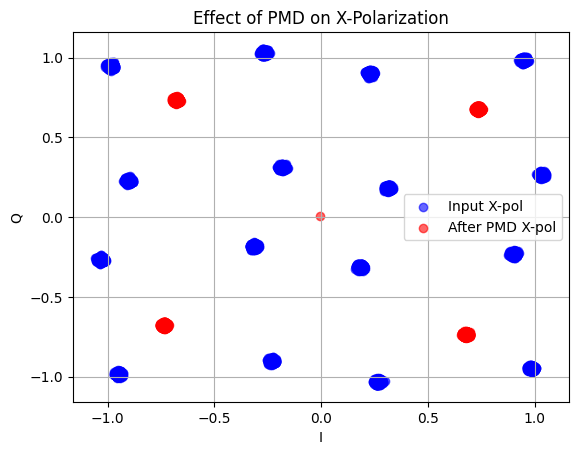

In [120]:
xpol=np.array(result_x).squeeze()
y_pol=np.array(result_y).squeeze()
#print(xpol,y_pol)
# print(xpol)
#print(len(result))
plt.figure()
plt.scatter(E_out[:,0].real, E_out[:,0].imag, color='blue', label='Input X-pol', alpha=0.6)
plt.scatter(result_py_func_x.real, result_py_func_x.imag, color='red', label='After PMD X-pol', alpha=0.6)
plt.xlabel('I')
plt.ylabel('Q')
plt.legend()
plt.title('Effect of PMD on X-Polarization')
plt.grid(True)
plt.show()


In [121]:
print(taps)

{'pxx': array([-7.24894024e-04+0.00131459j,  7.42122631e-04-0.00172733j,
        8.58249041e-01-0.00152469j]), 'pxy': array([ 0.00028882-0.00320557j, -0.00049011+0.0059414j ,
        0.21209558+0.4662482j ]), 'pyx': array([ 0.00025111+0.00270878j, -0.00041945-0.00584694j,
       -0.21166247+0.46442222j]), 'pyy': array([ 7.70077930e-04+0.00087959j, -1.37904041e-03-0.00098414j,
        8.60668568e-01+0.00140801j])}


In [122]:
class UCB:
  def __init__(self, c=1.414):  #n is number of arms
    """The arms that we have decided is that we will have pxx,pxy,pyx,pyy all these are filters of num_taps=3 and the 
    number of values for each tap will be 3("the best we find from lms algorithm")"""

    """NOTE: Wont selecting the best 3 arms from lms algorithm bias the UCB algorithm? What is the point of this?
    Also the number of arms here will be 3^12 -> """

    """TODO: Find out the top 3 values from lms algorithm for each of the 12 coefficients"""


    set_of_coefficients = np.array([
        [taps['pxx'][0], 2e-02 + 0.02j, 3e-01 + 0.2j],
        [taps['pxx'][1], 1.01882164-0.00023138j, -3e-03 + 0.4j],
        [taps['pxx'][2], 0.01 - 0.2j, 0.05 - 0.005j],

        [taps['pxy'][0], 0.00095767-0.00555305j, 0.5 + 0.5j],
        [taps['pxy'][1], -2e-2 + 0.6j, 0.02 - 0.002j],
        [taps['pxy'][2], 0.1 - 0.1j, 0.035 + 0.7j],

        [taps['pyx'][0], 0.04 + 0.04j, 0.8 + 0.2j],
        [taps['pyx'][1], 0.2 - 0.2j, 0.6 - 0.007j],
        [taps['pyx'][2], 0.007 + 0.3j, -0.04607301+0.01568022j],

        [taps['pyy'][0], -0.02 + 0.9j, 0.3 + 0.0003j],
        [taps['pyy'][1], 0.08 - 0.008j, 0.89440943-0.0002495j],
        [taps['pyy'][2], -0.0003 - 0.0001j, -0.7 - 0.04j],
    ], dtype = complex)


    #TODO: Get input symbols from the matlab code file
    self.input_symbols = E_out
    
    self.input_symbols_x_pol = self.input_symbols[:,0]
    self.input_symbols_y_pol = self.input_symbols[:,1]


    def create_arm_array(set_of_coefficients):
        # I take in the set of coefficients and then create all possible 3^12 combinations
        final_out = []
        temp=[]
        def add(set_of_coefficients,curr_ind):
            if curr_ind == len(set_of_coefficients):
                #print(temp)
                final_out.append(temp[:])
                # print(final_out)
                return

            for i in range(len(set_of_coefficients[0])):
                temp.append(set_of_coefficients[curr_ind][i])
                add(set_of_coefficients,curr_ind+1)
                temp.pop()

            return final_out
        return add(set_of_coefficients,0)

    self.arms = np.array(create_arm_array(set_of_coefficients))   
    

    self.radius=1
    self.filter_lengths=5
    self.cur_ind=self.filter_lengths
    self.n_arm = len(self.arms)                  
    self.arm_avg = np.zeros(len(self.arms))                  #sample mean reward for nth arm
    self.arm_pick = np.ones(len(self.arms))                  # number of times each arm has been picked
    self.c = c
    self.rounds = 0                                          # total number of rounds played till now
    self.rews = []
  
  
  def reward_func(self,arm,current_index):
     #Here arm is a set of 12 elements and i split it into its different components
      #For now I am finding the output for the first 100 symbols for x_pol and y_pol might have to change this to more later
    pxx=arm[:3]
    pxy=arm[3:6]
    pyx=arm[6:9]
    pyy=arm[9:12]

    predicted_symbol_x=np.convolve(self.input_symbols_x_pol[:1000], pxx, mode='same') + np.convolve(self.input_symbols_y_pol[:1000], pxy, mode='same')
    predicted_symbol_y= np.convolve(self.input_symbols_x_pol[:1000], pyx, mode='same') + np.convolve(self.input_symbols_y_pol[:1000], pyy, mode='same')

    return -(np.sum((self.radius-abs(predicted_symbol_x))**2)+np.sum((self.radius-abs(predicted_symbol_y))**2))

  def initialise(self): #playing each arm once
    self.arm_avg = np.array([self.reward_func(arm,self.filter_lengths) for arm in self.arms])

  def best_arm(self):
    return np.argmax(self.arm_avg + self.c * (np.array([np.log(self.rounds)])/self.arm_pick)**0.5)

  def update(self,rounds=1):
    #I am setting rounds = 1 so that every timestep we play one round
    self.rounds += rounds
    for i in range(rounds):
      arm_index = self.best_arm()
      reward = self.reward_func(self.arms[arm_index],self.cur_ind)
      self.cur_ind+=1
      if self.cur_ind==len(self.input_symbols[0]):
         self.cur_ind=self.filter_lengths
      
      num = ( self.arm_avg[arm_index] * self.arm_pick[arm_index] + reward )
      denom = (self.arm_pick[arm_index] + 1.0)
      self.arm_avg[arm_index] = num / denom
      self.arm_pick[arm_index] += 1
      self.rews.append(reward)

  def plotter(self):
    rews = np.cumsum(self.rews).astype(float)
    for i in range(len(rews)):
      rews[i] = rews[i]/(i+1.0)
    plt.plot(range(1,len(rews)+1),rews)

In [123]:
obj=UCB()
obj.initialise()

In [124]:
obj.update(10000)
print(obj.arms[obj.best_arm()])
print(obj.arm_avg[0])
print(obj.arm_avg[obj.best_arm()])
print(taps)

[-7.24894024e-04+0.00131459j  7.42122631e-04-0.00172733j
  8.58249041e-01-0.00152469j  2.88819197e-04-0.00320557j
 -4.90114972e-04+0.0059414j   2.12095579e-01+0.4662482j
  2.51108897e-04+0.00270878j -4.19445982e-04-0.00584694j
 -2.11662470e-01+0.46442222j  7.70077930e-04+0.00087959j
 -1.37904041e-03-0.00098414j  8.60668568e-01+0.00140801j]
-2.0508010557502128
-2.0508010557502128
{'pxx': array([-7.24894024e-04+0.00131459j,  7.42122631e-04-0.00172733j,
        8.58249041e-01-0.00152469j]), 'pxy': array([ 0.00028882-0.00320557j, -0.00049011+0.0059414j ,
        0.21209558+0.4662482j ]), 'pyx': array([ 0.00025111+0.00270878j, -0.00041945-0.00584694j,
       -0.21166247+0.46442222j]), 'pyy': array([ 7.70077930e-04+0.00087959j, -1.37904041e-03-0.00098414j,
        8.60668568e-01+0.00140801j])}


In [125]:
ideal_best_arm=np.concatenate((taps['pxx'],taps['pxy'],taps['pyx'],taps['pyy']))
print(ideal_best_arm)
print(obj.reward_func(ideal_best_arm,1))
print(obj.reward_func(obj.arms[obj.best_arm()],1))

[-7.24894024e-04+0.00131459j  7.42122631e-04-0.00172733j
  8.58249041e-01-0.00152469j  2.88819197e-04-0.00320557j
 -4.90114972e-04+0.0059414j   2.12095579e-01+0.4662482j
  2.51108897e-04+0.00270878j -4.19445982e-04-0.00584694j
 -2.11662470e-01+0.46442222j  7.70077930e-04+0.00087959j
 -1.37904041e-03-0.00098414j  8.60668568e-01+0.00140801j]
-2.05080105575026
-2.05080105575026


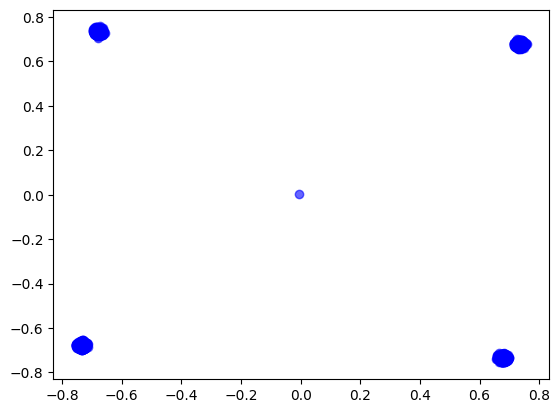

In [126]:
best_arm_found=obj.arms[obj.best_arm()]
x_out = np.convolve(E_out[:,0], best_arm_found[:3], mode='same') + np.convolve(E_out[:,1], best_arm_found[3:6], mode='same')
y_out = np.convolve(E_out[:,0], best_arm_found[6:9], mode='same') + np.convolve(E_out[:,1], best_arm_found[9:12], mode='same')

plt.scatter(x_out.real, x_out.imag, color='blue', label='After PMD X-pol', alpha=0.6)